In [1]:
import paths as paths
import shared.locals as locals
from tinydb import where
from datetime import datetime, timedelta
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, User

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

start_date = datetime.utcfromtimestamp(config.start_timestamp)
limit_date = datetime.utcfromtimestamp(config.limit_timestamp)

delta = limit_date - start_date
days = [(start_date+timedelta(days=i)).date() for i in range(delta.days + 1)]
years = {day.year for day in days}

activity_result = {year: {} for year in years}
users = [user for user in database.all(User.LABEL)]

for user in users:
    user_result = {year: {day: 0 for day in days if day.year == year} for year in years}

    for commit in database.query(Commit.LABEL, query=where("author_id") == user.id):
        date = datetime.utcfromtimestamp(commit.timestamp).date()
        user_result[date.year][date] += 1

    for year in years:
        activity_result[year][user.id] = user_result[year]

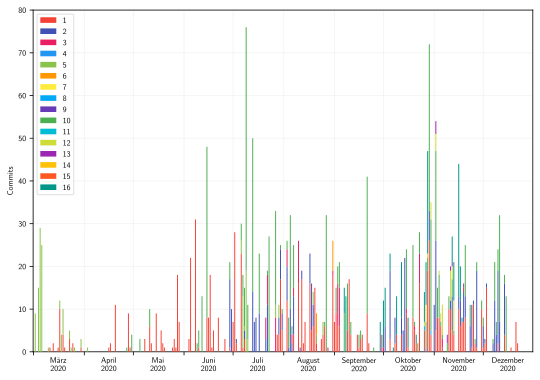

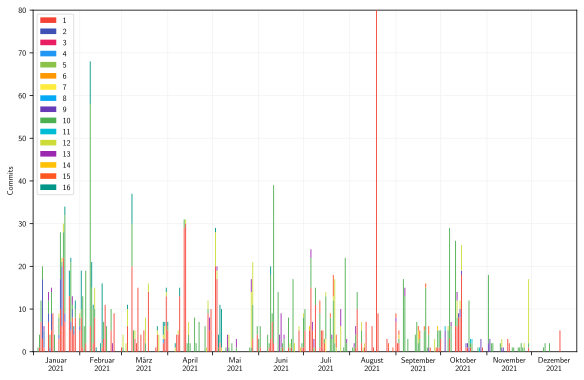

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import shared.locals as locals
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)

for year in years:
    fig, ax = plt.subplots(
        figsize=(locals.TEXTHEIGHT_SMALL if year == 2020 else locals.TEXTHEIGHT,
        locals.TEXTWIDTH * 0.9))

    for index, (user, user_result) in enumerate(activity_result[year].items()):
        dates = list(user_result.keys())
        values = list(user_result.values())
        
        if index == 0:
            bottom = None
        else:
            bottom = np.array(list(activity_result[year][users[0].id].values()))

            for previous_dataset in range(1, index):
                bottom += np.array(list(activity_result[year][users[previous_dataset].id].values()))

        ax.bar(dates, values, bottom=bottom, color=locals.USERS[user]["color"],
            label=locals.USERS[user]["id"], width=0.6, alpha=1, zorder=3)

    ax.legend(loc="upper left", edgecolor=locals.FRAME_GRAY)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%B\n%Y"))
    ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

    ax.margins(x=0)
    ax.set_ylabel("Commits")
    ax.set_ylim([0,80])
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=10))
    ax.grid(color=locals.GRID_GRAY)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()